# Evaluation and hyperparameter tuning

In the previous notebook, we saw two approaches to tune hyperparameters.
However, we did not present a proper framework to evaluate the tuned models.
Instead, we focused on the mechanism used to find the best set of parameters.

In this notebook, we reuse some knowledge presented in the module "Selecting
the best model" to show how to evaluate models where hyperparameters need to
be tuned.

Thus, we first load the dataset and create the predictive model that we want
to optimize and later on, evaluate.

## Loading the dataset

As in the previous notebook, we load the Adult census dataset. The loaded
dataframe is first divided to separate the input features and the target into
two separated variables. In addition, we drop the column `"education-num"` as
previously done.

In [1]:
import pandas as pd

target_name = "class"
url = "https://raw.githubusercontent.com/INRIA/scikit-learn-mooc/master/datasets/adult-census.csv"
adult_census = pd.read_csv(url)
target = adult_census[target_name]
data = adult_census.drop(columns=[target_name, "education-num"])

## Our predictive model

We now create the predictive model that we want to optimize. Note that this
pipeline is identical to the one we used in the previous notebook.

In [2]:
from sklearn.compose import make_column_selector as selector, ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier

cat_col=  selector(dtype_include = object)(data)
num_col = selector(dtype_exclude = object)(data)

cat_preprocessor = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
num_preprocessor = StandardScaler()

preprocessor = ColumnTransformer(
    [('cat preprocessor', cat_preprocessor, cat_col),
     ('num preprocessor', num_preprocessor, num_col)
    ],
    remainder='passthrough'
)

model = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('classifier', HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4))
    ]
)
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country']),
                                                 ('num preprocessor',
                                                  StandardScaler(),
                                                  ['age', 'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
preprocessor = ColumnTransformer(
    [
        ("cat_preprocessor", categorical_preprocessor, categorical_columns),
    ],
    remainder="passthrough",
)

In [4]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4),
        ),
    ]
)
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

## Evaluation

### Without hyperparameter tuning

In the module "Selecting the best model", we saw that one must use
cross-validation to evaluate such a model. Cross-validation allows to get a
distribution of the scores of the model. Thus, having this distribution at
hand, we can get to assess the variability of our estimate of the
generalization performance of the model. Here, we recall the necessary
`scikit-learn` tools needed to obtain the mean and standard deviation of the
scores.

In [5]:
# To stop the warning
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4'  # Replace '4' with the number of cores you want to use

In [6]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, data, target, cv=5)
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_score
0,0.244364,0.037885,0.863241
1,0.238945,0.038115,0.860784
2,0.264240,0.033259,0.860360
3,0.233863,0.039298,0.862408
4,0.228953,0.031291,0.866912


The cross-validation scores are coming from a 5-fold cross-validation. So we
can compute the mean and standard deviation of the generalization score.

In [7]:
print(
    "Generalization score without hyperparameters"
    f" tuning:\n{cv_results['test_score'].mean():.3f} ±"
    f" {cv_results['test_score'].std():.3f}"
)

Generalization score without hyperparameters tuning:
0.863 ± 0.003


We now present how to evaluate the model with hyperparameter tuning, where an
extra step is required to select the best set of parameters.

### With hyperparameter tuning

As shown in the previous notebook, one can use a search strategy that uses
cross-validation to find the best set of parameters. Here, we use a
grid-search strategy and reproduce the steps done in the previous notebook.

First, we have to embed our model into a grid-search and specify the
parameters and the parameter values that we want to explore.

In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__learning_rate": (0.05, 0.5),
    "classifier__max_leaf_nodes": (10, 30),
}
model_grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=2, cv=2)
model_grid_search.fit(data, target)

c:\Users\npigeon1\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex',
                                                                          'native-country'])])),
                                       ('classifier',
                                        HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                                       random_state=42))]),
             n_jobs=2,
             param_grid={'classifier__learning_rate': (0.05, 0.5),
                         'classifier__max_leaf_nodes': (10, 30)})

As previously seen, when calling the `fit` method, the model embedded in the
grid-search is trained with every possible combination of parameters resulting
from the parameter grid. The best combination is selected by keeping the
combination leading to the best mean cross-validated score.

In [9]:
cv_results = pd.DataFrame(model_grid_search.cv_results_)
cv_results[
    [
        "param_classifier__learning_rate",
        "param_classifier__max_leaf_nodes",
        "mean_test_score",
        "std_test_score",
        "rank_test_score",
    ]
]

,param_classifier__learning_rate,param_classifier__max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
0,0.05,10,0.864195,0.000061,4
1,0.05,30,0.870910,0.000061,1
2,0.50,10,0.869457,0.000819,2
3,0.50,30,0.866365,0.001822,3


In [10]:
model_grid_search.best_params_

{'classifier__learning_rate': 0.05, 'classifier__max_leaf_nodes': 30}

One important caveat here concerns the evaluation of the generalization
performance. Indeed, the mean and standard deviation of the scores computed by
the cross-validation in the grid-search are potentially not good estimates of
the generalization performance we would obtain by refitting a model with the
best combination of hyper-parameter values on the full dataset. Note that
scikit-learn automatically performs this refit by default when calling
`model_grid_search.fit`. This refitted model is trained with more data than
the different models trained internally during the cross-validation of the
grid-search.

We therefore used knowledge from the full dataset to both decide our model’s
hyper-parameters and to train the refitted model.

Because of the above, one must keep an external, held-out test set for the
final evaluation of the refitted model. We highlight here the process using a
single train-test split.

In [11]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, test_size=0.2, random_state=42
)

model_grid_search.fit(data_train, target_train)
accuracy = model_grid_search.score(data_test, target_test)
print(f"Accuracy on test set: {accuracy:.3f}")

Accuracy on test set: 0.877


The score measure on the final test set is almost within the range of the
internal CV score for the best hyper-parameter combination. This is reassuring
as it means that the tuning procedure did not cause significant overfitting in
itself (other-wise the final test score would have been lower than the
internal CV scores). That is expected because our grid search explored very
few hyper-parameter combinations for the sake of speed. The test score of the
final model is actually a bit higher than what we could have expected from the
internal cross-validation. This is also expected because the refitted model is
trained on a larger dataset than the models evaluated in the internal CV loop
of the grid-search procedure. This is often the case that models trained on a
larger number of samples tend to generalize better.

In the code above, the selection of the best hyperparameters was done only on
the train set from the initial train-test split. Then, we evaluated the
generalization performance of our tuned model on the left out test set. This
can be shown schematically as follows

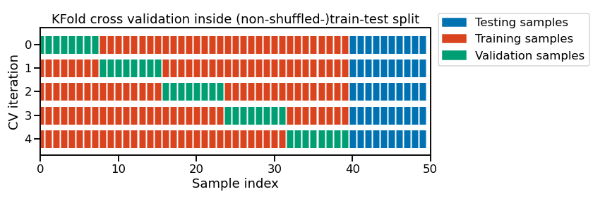

![Cross-validation tuning
diagram](../figures/cross_validation_train_test_diagram.png)

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p>This figure shows the particular case of <strong>K-fold</strong> cross-validation
strategy using <tt class="docutils literal">n_splits=5</tt> to further split the train set coming from a
train-test split.
For each cross-validation split, the procedure trains a model on all the red
samples, evaluates the score of a given set of hyperparameters on the green
samples. The best hyper-parameters are selected based on those intermediate
scores.</p>
<p>Then a final model tuned with those hyper-parameters is fitted on the
concatenation of the red and green samples and evaluated on the blue samples.</p>
<p class="last">The green samples are sometimes called a <strong>validation sets</strong> to differentiate
them from the final test set in blue.</p>
</div>

However, this evaluation only provides us a single point estimate of the
generalization performance. As recall at the beginning of this notebook, it is
beneficial to have a rough idea of the uncertainty of our estimated
generalization performance. Therefore, we should instead use an additional
cross-validation for this evaluation.

This pattern is called **nested cross-validation**. We use an inner
cross-validation for the selection of the hyperparameters and an outer
cross-validation for the evaluation of generalization performance of the
refitted tuned model.

In practice, we only need to embed the grid-search in the function
`cross_validate` to perform such evaluation.

In [12]:
cv_results = cross_validate(
    model_grid_search, data, target, cv=5, n_jobs=2, return_estimator=True
)

In [13]:
cv_results = pd.DataFrame(cv_results)
cv_test_scores = cv_results["test_score"]
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} ± {cv_test_scores.std():.3f}"
)

Generalization score with hyperparameters tuning:
0.871 ± 0.003


This result is compatible with the test score measured with the string outer
train-test split.

However, in this case, we can apprehend the variability of our estimate of the
generalization performance thanks to the measure of the standard-deviation of
the scores measured in the outer cross-validation.

Here is a schematic representation of the complete nested cross-validation
procedure:

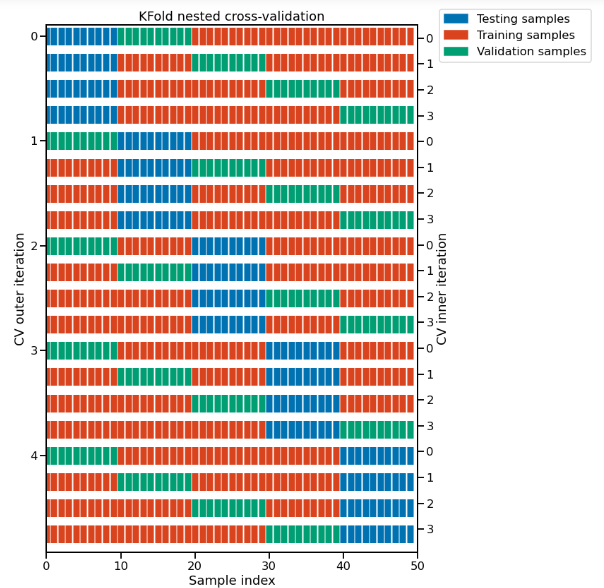

![Nested cross-validation
diagram](../figures/nested_cross_validation_diagram.png)

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p>This figure illustrates the nested cross-validation strategy using
<tt class="docutils literal">cv_inner = KFold(n_splits=4)</tt> and <tt class="docutils literal">cv_outer = KFold(n_splits=5)</tt>.</p>
<p>For each inner cross-validation split (indexed on the right-hand side),
the procedure trains a model on all the red samples and evaluate the quality
of the hyperparameters on the green samples.</p>
<p>For each outer cross-validation split (indexed on the left-hand side),
the best hyper-parameters are selected based on the validation scores
(computed on the green samples) and a model is refitted on the concatenation
of the red and green samples for that outer CV iteration.</p>
<p class="last">The generalization performance of the 5 refitted models from the outer CV
loop are then evaluated on the blue samples to get the final scores.</p>
</div>

In addition, passing the parameter `return_estimator=True`, we can check the
value of the best hyperparameters obtained for each fold of the outer
cross-validation.

In [19]:
for cv_fold, estimator_in_fold in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Best hyperparameters for fold #1:
{'classifier__learning_rate': 0.05, 'classifier__max_leaf_nodes': 30}
Best hyperparameters for fold #2:
{'classifier__learning_rate': 0.05, 'classifier__max_leaf_nodes': 30}
Best hyperparameters for fold #3:
{'classifier__learning_rate': 0.05, 'classifier__max_leaf_nodes': 30}
Best hyperparameters for fold #4:
{'classifier__learning_rate': 0.05, 'classifier__max_leaf_nodes': 30}
Best hyperparameters for fold #5:
{'classifier__learning_rate': 0.05, 'classifier__max_leaf_nodes': 30}


It is interesting to see whether the hyper-parameter tuning procedure always
select similar values for the hyperparameters. If it is the case, then all is
fine. It means that we can deploy a model fit with those hyperparameters and
expect that it will have an actual predictive performance close to what we
measured in the outer cross-validation.

But it is also possible that some hyperparameters do not matter at all, and as
a result in different tuning sessions give different results. In this case,
any value will do. This can typically be confirmed by doing a parallel
coordinate plot of the results of a large hyperparameter search as seen in the
exercises.

From a deployment point of view, one could also choose to deploy all the
models found by the outer cross-validation loop and make them vote to get the
final predictions. However this can cause operational problems because it uses
more memory and makes computing prediction slower, resulting in a higher
computational resource usage per prediction.

In this notebook, we have seen how to evaluate the predictive performance of a
model with tuned hyper-parameters using the nested cross-validation procedure.